# PIMENTO
## Physics-Informed Machine LEarning non-stationary Temporal Forecasting
### Developed by: Puja Chowdhury
#### Date: 07/18/2023

## Model Architecture
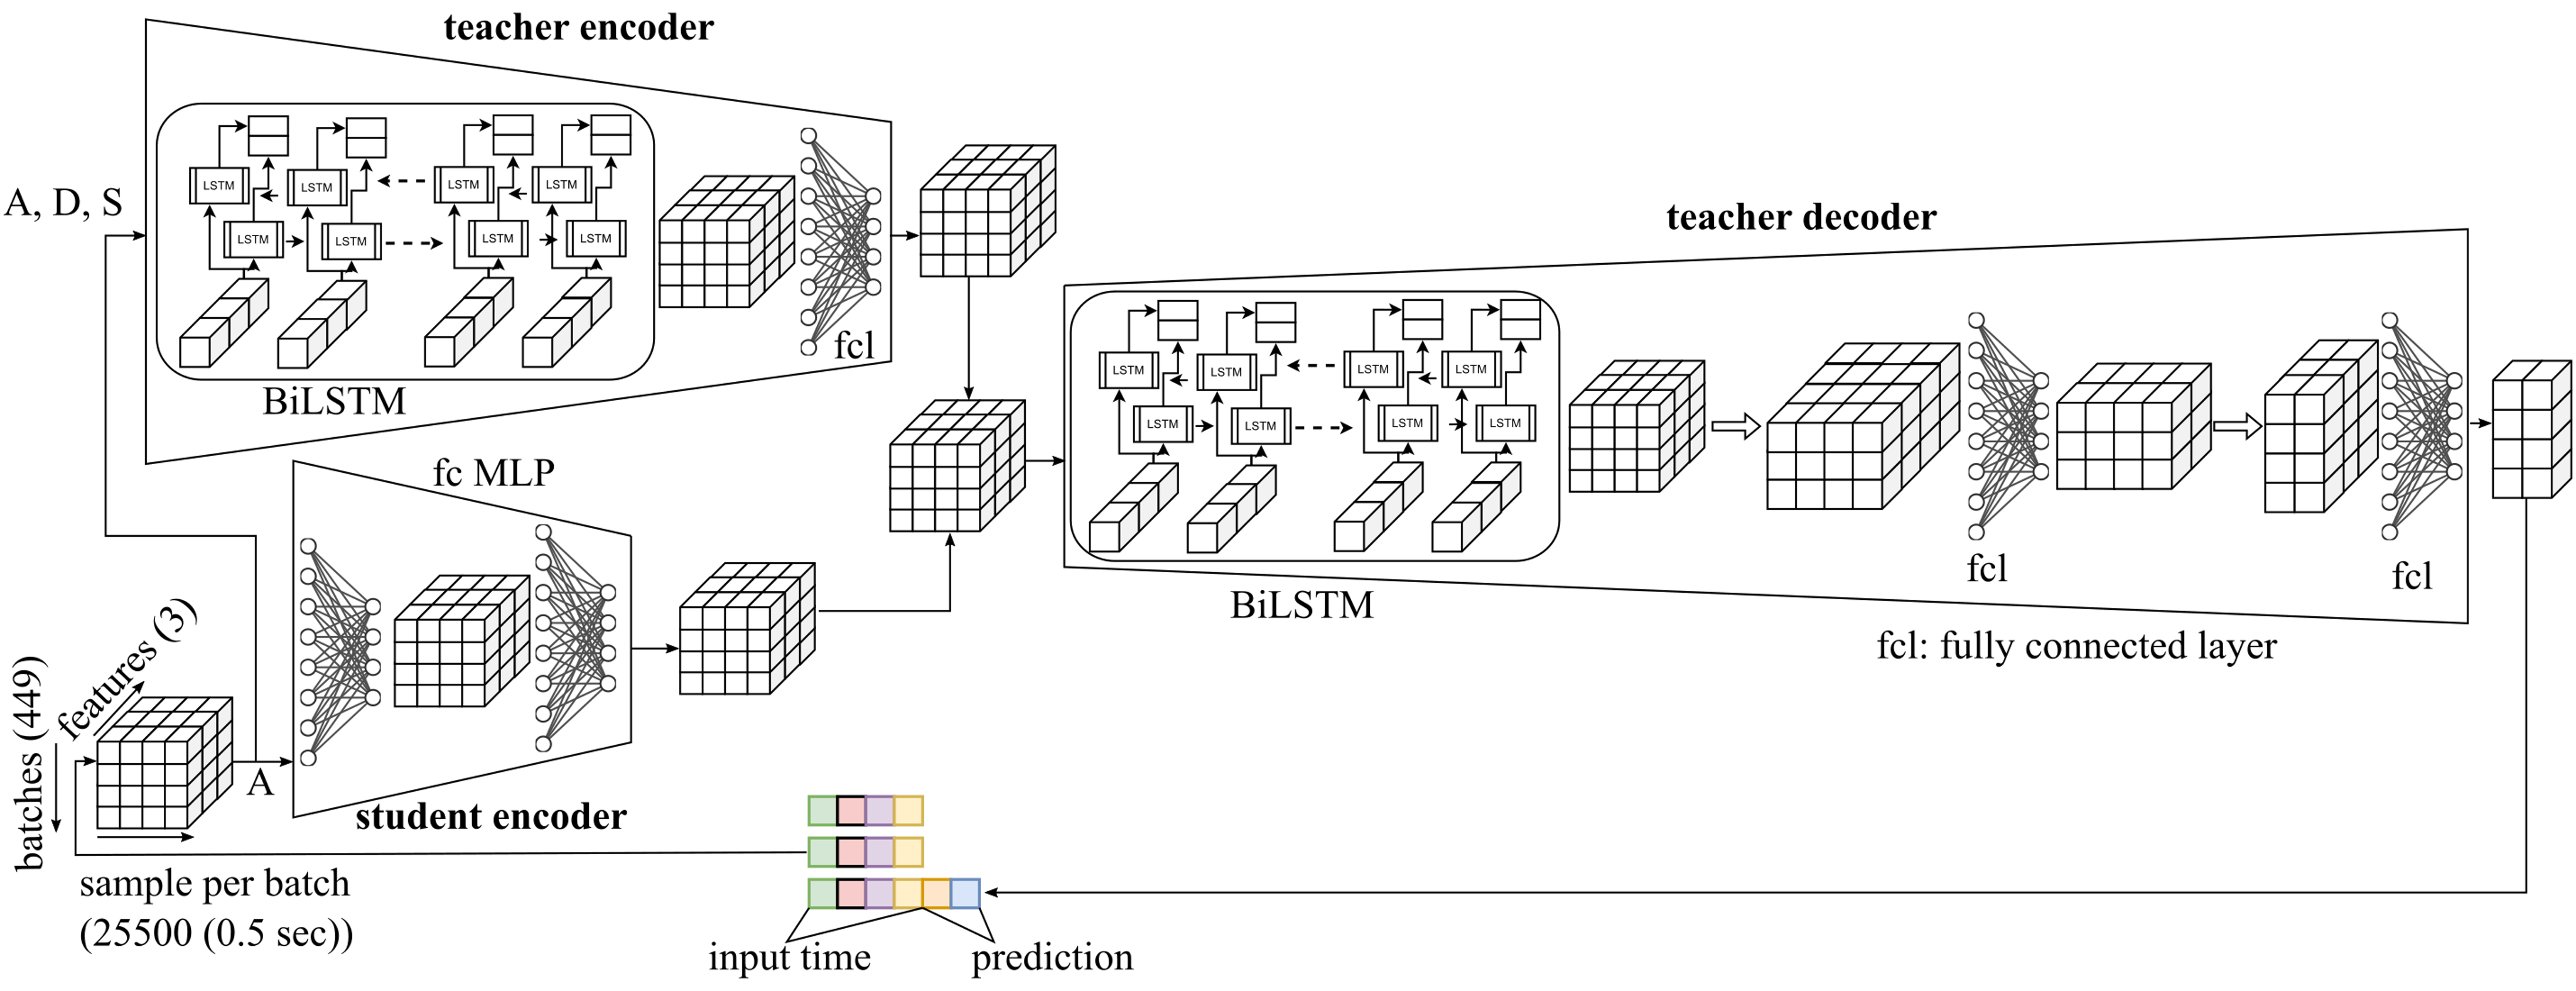

## Running Instructions
This model will be run by the 'run_model.py' file.
If you want to change the configuration of the model then change the values in the 'configuration.py' file before executing the 'run_model.py' file.

In [1]:
#%% Importing libraries
import configuration as config
import torch
torch.manual_seed(0) # initialization of the layers
torch.backends.cudnn.deterministic = True # make the experiment reproducible,
# similar to set random seed to all options where there needs a random seed
torch.backends.cudnn.benchmark = True # True, cuDNN will use some heuristics at the beginning of your training to figure out which algorithm will be most performant for your model architecture and input.
# This might be especially helpful, if your input shapes are fixed and not changing a lot during training.
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import pickle
import data_processor
import PIMENTO
import utilities

Running on the GPU
Number of GPU 1
GPU type TITAN RTX
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


C:\ProgramData\Anaconda3\envs\neural-subgraph-learning-GNN-master\lib\site-packages\torch\cuda\memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [2]:
#%% Setting device
device = config.device
## setting the mode
train_teacher = config.train_teacher
train_student = config.train_student

## Data Preparation

In [4]:
## Reading data
filename = config.input_file
df_raw=pd.read_csv(filename,skiprows=0)

## Data Extraction as numpy array
acceleration=df_raw['Acceleration'].to_numpy()
time=df_raw['Time (sec)'].to_numpy()
deformation=df_raw['TD_Average [m]'].to_numpy()#TotalDefprmation average
strain=df_raw['EES_Average [m/m]'].to_numpy()#EES(equivalant elastic strain) average
deformation_x=df_raw['D_X_Average [m]'].to_numpy()#deformation x axies
deformation_y=df_raw['D_Y_Average [m]'].to_numpy()#deformation y axies
deformation_z=df_raw['D_Z_Average [m]'].to_numpy()#deformation z axies
## Adding all features together
features_ads_all = np.vstack((acceleration, deformation, strain, deformation_x, deformation_y, deformation_z))
features_ads = features_ads_all[0:config.num_features, :] # Selecting features based on configuration

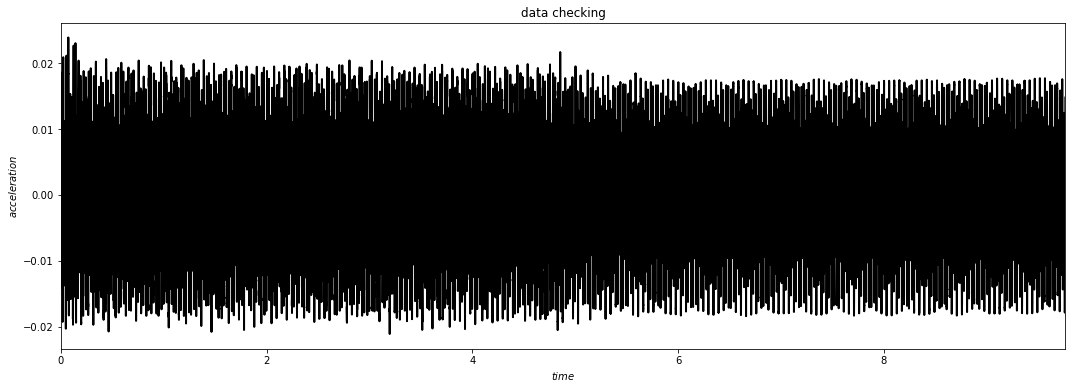

In [5]:
## data checking
plt.figure(figsize = (18, 6))
plt.plot(time, features_ads[0], color = 'k', linewidth = 2)
plt.xlim([time[0], time[-1]])
plt.xlabel('$time$')
plt.ylabel('$acceleration$')
plt.title('data checking')
plt.savefig('../plots/acceleration.png')
plt.show()

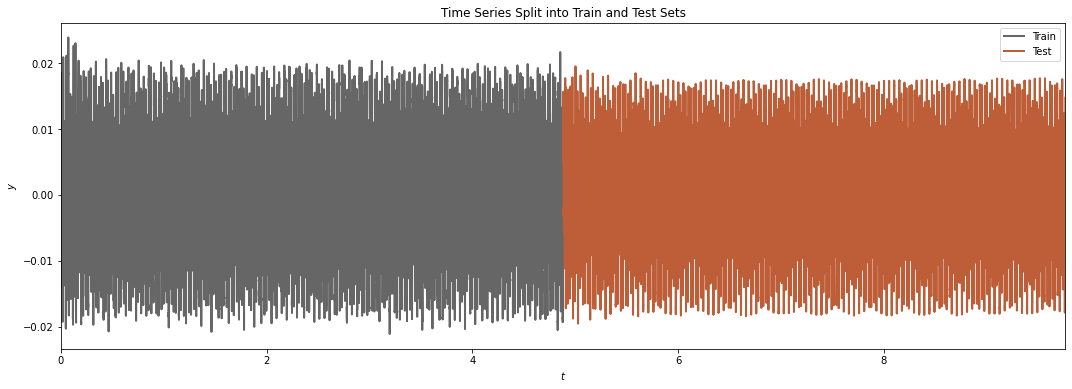

In [6]:
## train and test splitting
time_train, ads_train, time_test, ads_test = data_processor.train_test_split(time, features_ads, split = 0.5)

## plot time series with train/test split
plt.figure(figsize = (18, 6))
plt.plot(time_train, ads_train[0,:].ravel(), color = '0.4', linewidth = 2, label = 'Train')
plt.plot(np.concatenate([[time_train[-1]], time_test]), np.concatenate([[ads_train[0,:].ravel()[-1]], ads_test[0,:].ravel()]),
         color = (0.74, 0.37, 0.22), linewidth = 2, label = 'Test')
plt.xlim([time[0], time[-1]])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Time Series Split into Train and Test Sets')
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout
plt.savefig('../plots/train_test_split.png')
plt.show()

In [7]:
## set size of input/output windows
Ts=(time[-1]-time[0])/time.shape[0]
Fs =math.floor(1/Ts) # mainly used for plotting figures
if config.time_based:
    input_time=config.input_time #training time
    time_to_predict= config.time_to_predict # time of prediction
    series_length= config.series_length
    sliding_size= config.sliding_size
    computation_time= config.computation_time
    iw = int((input_time)* Fs)
    ow = int(time_to_predict * Fs)
    s = math.ceil((sliding_size)* Fs) # stride
else:
    iw = config.input_window # int((input_time)* Fs)
    ow = config.output_window # int(time_to_predict * Fs)
    s = config.stride # math.ceil((sliding_size)* Fs) # stride

## Read whole series data and train the standard scalar
X_IN, Y_Truth, std_scalar = data_processor.windowed_dataset(features_ads, num_features=config.num_features,
                                                              input_window=iw, output_window=ow, stride=s,
                                                              return_std_scalar=True)
## Saving std_scalar as pickle
with open(config.std_scalar_file, 'wb') as file:
    pickle.dump(std_scalar, file) # saving the std_scalar

Training data shape (25500, 449, 1) and testing data shape (25500, 449, 1)


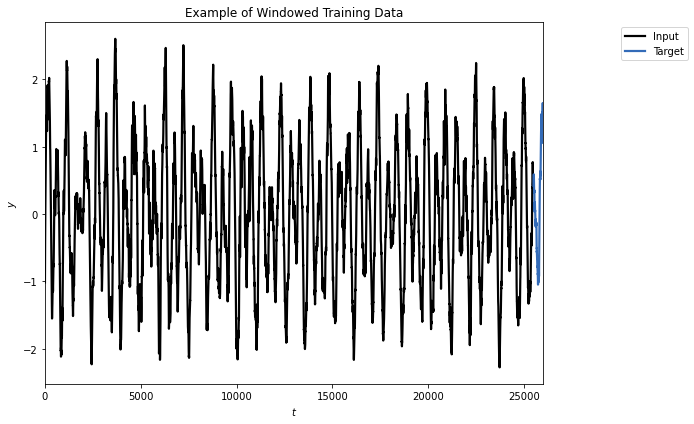

In [8]:
## generate windowed training/test datasets
Xtrain, Ytrain= data_processor.windowed_dataset(ads_train, num_features = config.num_features,
                                                  input_window = iw, output_window = ow, stride = s, std_scalar = std_scalar, return_std_scalar = False)
Xtest, Ytest = data_processor.windowed_dataset(ads_test, num_features = config.num_features,
                                                 input_window = iw, output_window = ow, stride = s, std_scalar = std_scalar, return_std_scalar = False)
print("Training data shape {} and testing data shape {}".format(Xtrain.shape, Xtest.shape))

## plot example of windowed data
plt.figure(figsize = (10, 6))
plt.plot(np.arange(0, iw), Xtrain[:, 0, 0], 'k', linewidth = 2.2, label = 'Input')
plt.plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtrain[-1, 0, 0]], Ytrain[:, 0, 0]]),
         color = (0.2, 0.42, 0.72), linewidth = 2.2, label = 'Target')
plt.xlim([0, iw + ow - 1])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Example of Windowed Training Data')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.savefig('../plots/windowed_data.png')
plt.show()

## convert windowed data from np.array to PyTorch tensor
X_train, Y_train, X_test, Y_test = data_processor.numpy_to_torch(Xtrain, Ytrain, Xtest, Ytest)

## Teacher Model

In [9]:
# specify model parameters and train the teacher model
## Defining teacher model
teacher_model = PIMENTO.lstm_seq2seq(input_length=iw, output_length=ow,input_size = X_train.shape[2],
                                hidden_size = config.hidden_size, encoder_size=config.encoder_size, 
                                     layer_dim=config.num_layers, bidirectional=config.bidirectional).to(device)

In [10]:
## Training of testing teacher model
if train_teacher: # train teacher
    losses_teacher = PIMENTO.train_model(teacher_model, X_train.to(device), Y_train.to(device), n_epochs = config.n_epochs,
                                         batch_size = config.batch_size,learning_rate = config.learning_rate_teacher,
                                         weight_decay=config.weight_decay)

    ## saving model
    torch.save(teacher_model.state_dict(), config.teacher_chkpt)
    print('Teacher Model Saved')
else: # testing teacher
    ## loading model
    teacher_chpt = torch.load(config.teacher_chkpt, map_location=torch.device(device))
    teacher_model.load_state_dict(teacher_chpt)
    print("Teacher Model Loaded")
    if not train_student:
        teacher_model.eval()

100%|██████████████████████████████████████████████████████████████████████| 50/50 [01:14<00:00,  1.49s/it, loss=0.083]

Teacher Model Saved


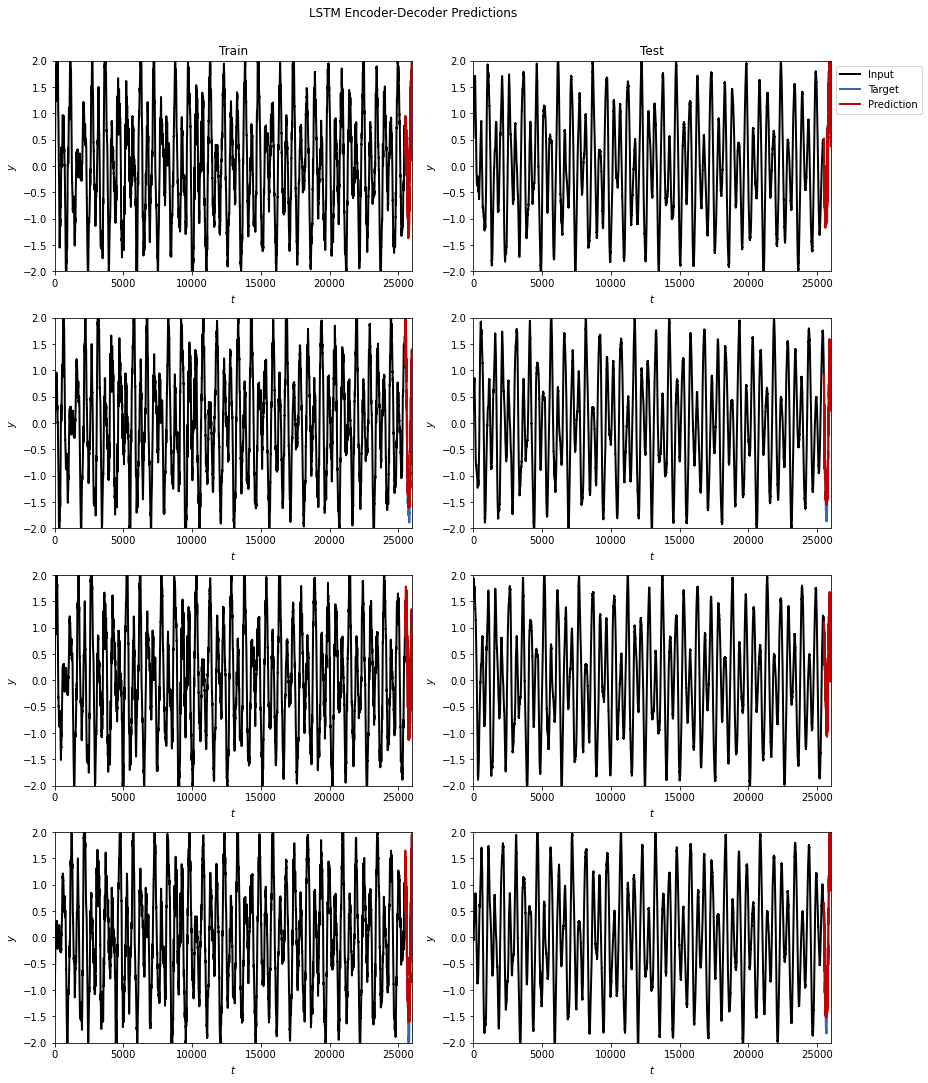

Average RMSE on test data of Teacher Model 1.1347980576220875e-05


In [11]:
## checking teacher performance
utilities.plot_train_test_results(teacher_model, Xtrain, Ytrain, Xtest, Ytest, num_rows=4, filename= config.teacher_plot)
print("Average RMSE on test data of Teacher Model {}".format(utilities.mse_calculation(teacher_model, Xtest, Ytest, ow, rmse = True, std_scalar = std_scalar)))

RMSE of Teacher Model on whole series data 1.1906709164404366e-05
MAE of Teacher Model on whole series data 0.002726763789650507


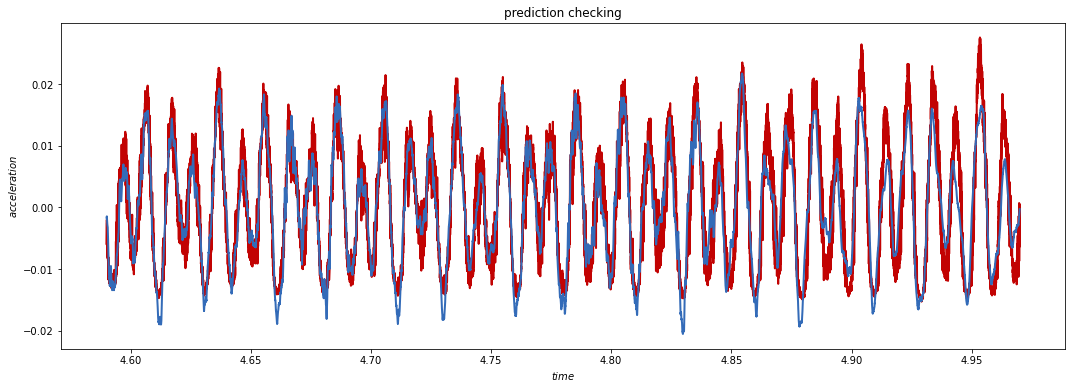

In [12]:
## Whole series for teacher model
Y_Truth_All, Y_Pred_All, rmse_error, mae_error = utilities.whole_series_prediction(teacher_model, X_IN, Y_Truth, std_scalar, target_len=ow, rmse = True)
print("RMSE of Teacher Model on whole series data {}".format(rmse_error))
print("MAE of Teacher Model on whole series data {}".format(mae_error))
## Plotting whole series
plt.figure(figsize = (18, 6))
time_chunk = time[config.input_window:]
chunk_start = int(Fs*4.59)-config.input_window
chunk_end = int(Fs*4.97)-config.input_window
plt.plot(time_chunk[chunk_start:chunk_end], Y_Pred_All[chunk_start:chunk_end], color=(0.76, 0.01, 0.01), linewidth=2, label='Prediction')
plt.plot(time_chunk[chunk_start:chunk_end],Y_Truth_All[chunk_start:chunk_end], color=(0.2, 0.42, 0.72), linewidth=2, label='Target')
# plt.xlim([time[0], time[-1]])
plt.xlabel('$time$')
plt.ylabel('$acceleration$')
plt.title('prediction checking')
plt.savefig(config.teacher_plot_whole)
plt.show()

## Student Model

In [13]:
## Defining student model
student_model = PIMENTO.lstm_seq2seq(input_length=iw, output_length=ow,input_size = X_train[:,:,0].unsqueeze(-1).shape[2],
                                     hidden_size = config.hidden_size, encoder_size= config.encoder_size,
                                      layer_dim=config.num_layers, bidirectional=config.bidirectional, student_mode = True).to(device)


In [14]:
## Training or testing student model
if train_student: # training student model
    PIMENTO.train_student_model(teacher_model, student_model, X_train.to(device), Y_train.to(device),
                                n_epochs=config.n_epochs_student, batch_size=config.batch_size,
                                learning_rate = config.learning_rate_student, weight_decay=config.weight_decay_student)

    # saving models
    torch.save(student_model.state_dict(), config.student_chkpt)
    print('Student Model saved')
else: # testing student model
    # loading model
    student_chpt = torch.load(config.student_chkpt, map_location=torch.device(device))
    student_model.load_state_dict(student_chpt)
    print("Student Model Loaded")
    student_model.eval()

100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:44<00:00,  1.13it/s, loss=0.149]


Student Model saved


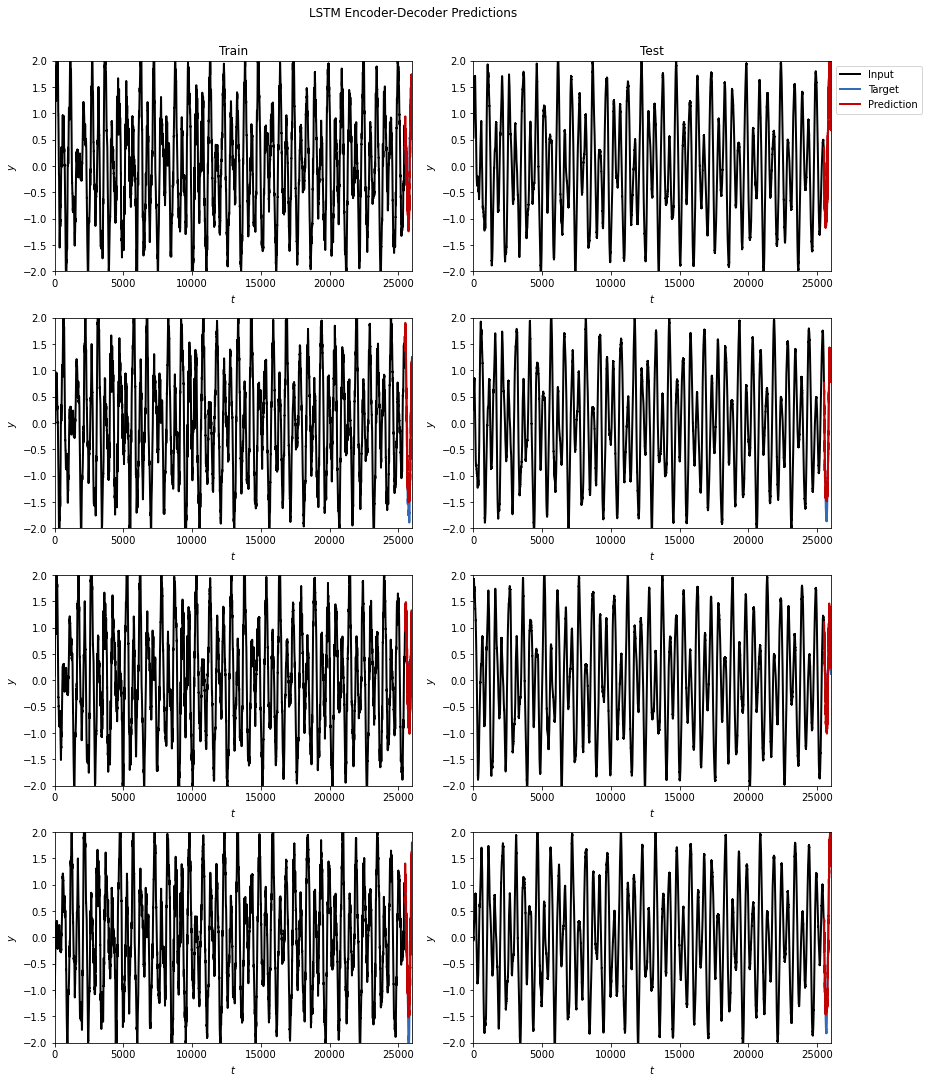

Average RMSE on test data of Student Model 6.7681205074866725e-06


In [15]:
## checking student performance
utilities.plot_train_test_results(student_model, Xtrain, Ytrain, Xtest, Ytest, num_rows=4, filename=config.student_plot, student_version=True)
print("Average RMSE on test data of Student Model {}".format(utilities.mse_calculation(student_model, Xtest, Ytest, ow, student_mode = True, rmse = True, std_scalar = std_scalar)))

RMSE of Student Model on whole series data 7.472598896055083e-06
MAE of Student Model on whole series data 0.0022260535505713827


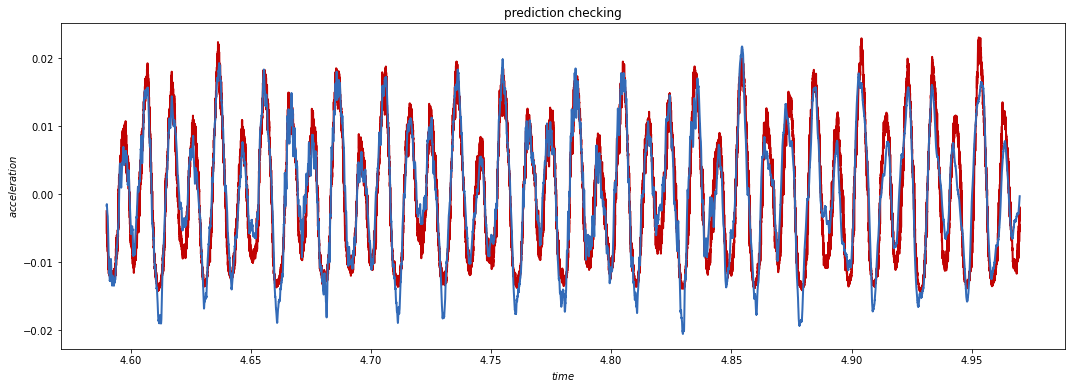

In [16]:
## Whole series for student model
Y_Truth_All, Y_Pred_All, rmse_error, mae_error = utilities.whole_series_prediction(student_model, X_IN, Y_Truth, std_scalar, target_len=ow, student_mode = True, rmse = True)
print("RMSE of Student Model on whole series data {}".format(rmse_error))
print("MAE of Student Model on whole series data {}".format(mae_error))
## Plotting whole series
plt.figure(figsize = (18, 6))
time_chunk = time[config.input_window:]
chunk_start = int(Fs*4.59)-config.input_window
chunk_end = int(Fs*4.97)-config.input_window
plt.plot(time_chunk[chunk_start:chunk_end], Y_Pred_All[chunk_start:chunk_end], color=(0.76, 0.01, 0.01), linewidth=2, label='Prediction')
plt.plot(time_chunk[chunk_start:chunk_end],Y_Truth_All[chunk_start:chunk_end], color=(0.2, 0.42, 0.72), linewidth=2, label='Target')
# plt.xlim([time[0], time[-1]])
plt.xlabel('$time$')
plt.ylabel('$acceleration$')
plt.title('prediction checking')
plt.savefig(config.student_plot_whole)
plt.show()